In [179]:
#setup
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from IPython.display import display
from pprint import pprint
from unidecode import unidecode
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)
pd.options.mode.chained_assignment = None #disable a specific warning when writing on a copy of a df 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Creating the csv

In [180]:
from main import nlp_pipeline_result

# data = nlp_pipeline_result(
#     parser_parameters={
#         "remove_hashtag_word": True,
#         "replace_politics": True,
#         "replace_parties": True,
#     },
#     nlp_parameters={
#         "disable_parser": True,
#         "disable_ner": True
#     }
# )
# data['n_lemmas'] = data['Lemmas'].str.split().str.len()
# 
# data.to_csv('data/data.csv', index = False)

# Spliting train and test

In [181]:
data = pd.read_csv('data/data.csv')

train = data.sample(frac=0.8, random_state=420)
test = data.drop(train.index)
data = train

print(f"Len data: {len(data)}")
print(f"Len train: {len(train)}")
print(f"Len test: {len(test)}")

Len data: 11850
Len train: 11850
Len test: 2962


# Parsing Lemmas

In [182]:
def remove_accents(sentence):
    parsed_sentence = []
    for word in sentence.split(" "):
        if "ñ" in word:
            parsed_sentence.append(word)
        else:
            parsed_sentence.append(unidecode(word))
    return " ".join(parsed_sentence)

In [183]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_accents(str(x).lower()))
mayor_5_parties = data['Party'].value_counts().index[:5]
data['Mayor Parties'] = data['Party'].apply(lambda x: x if x in mayor_5_parties else 'Other')

In [184]:
color_assign = {'Vox':sns.color_palette()[2], 
                'PP':sns.color_palette()[0],
                'PSOE':sns.color_palette()[3], 
                'Unidas Podemos':sns.color_palette()[4], 
                'Ciudadanos':sns.color_palette()[1],
                'Other':sns.color_palette()[7]}

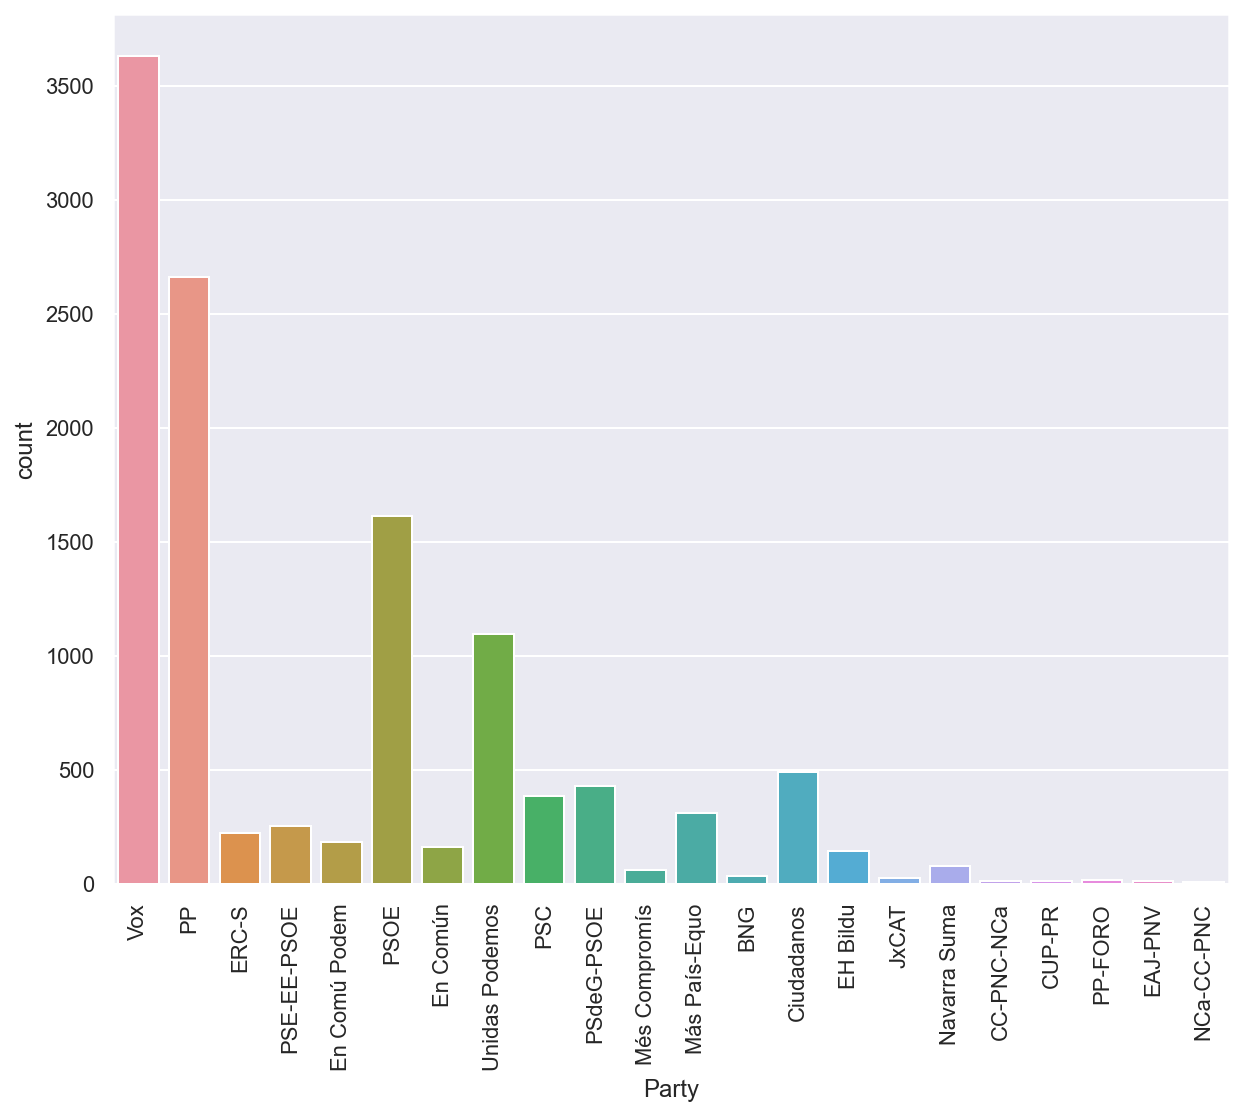

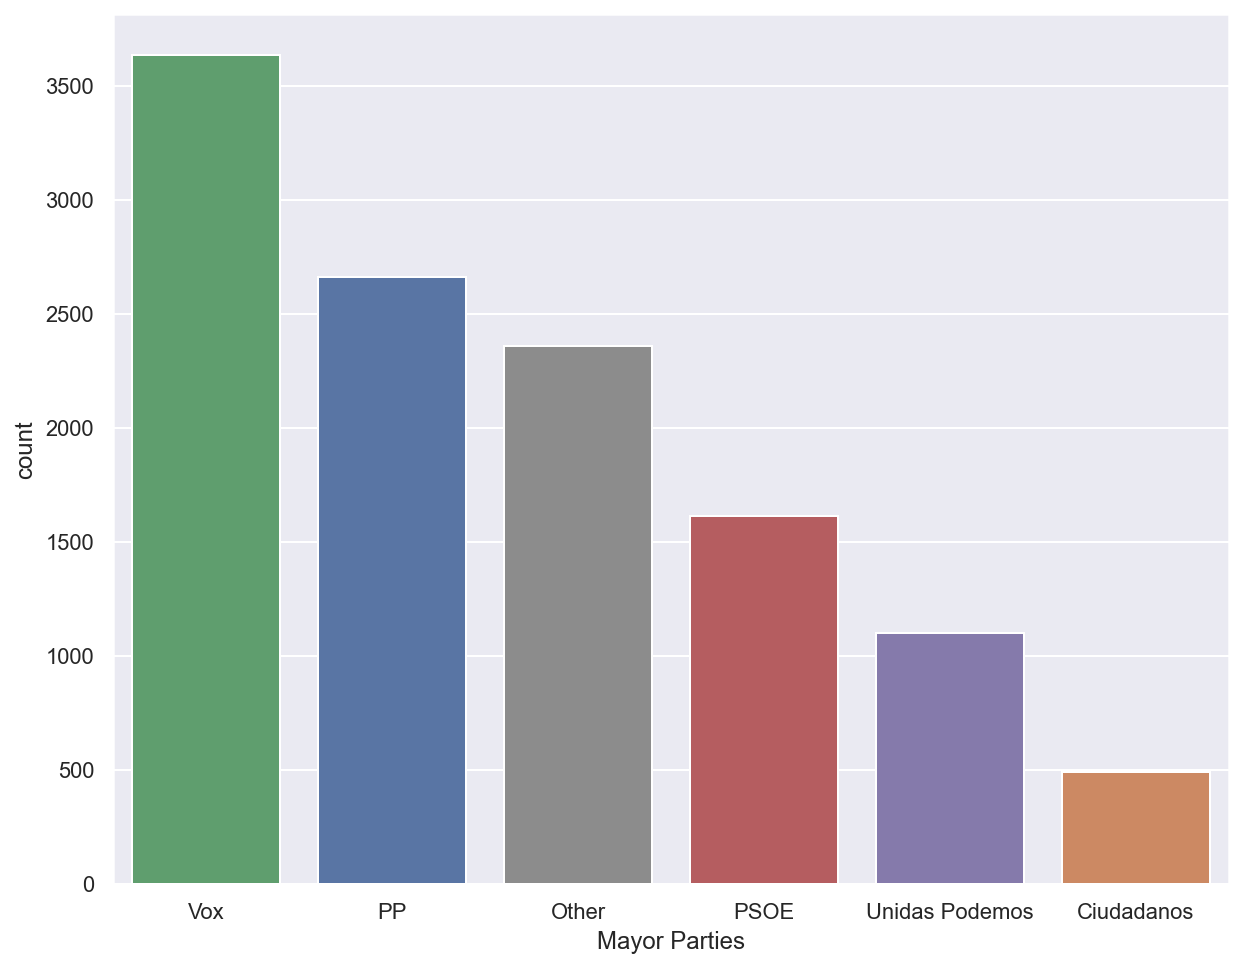

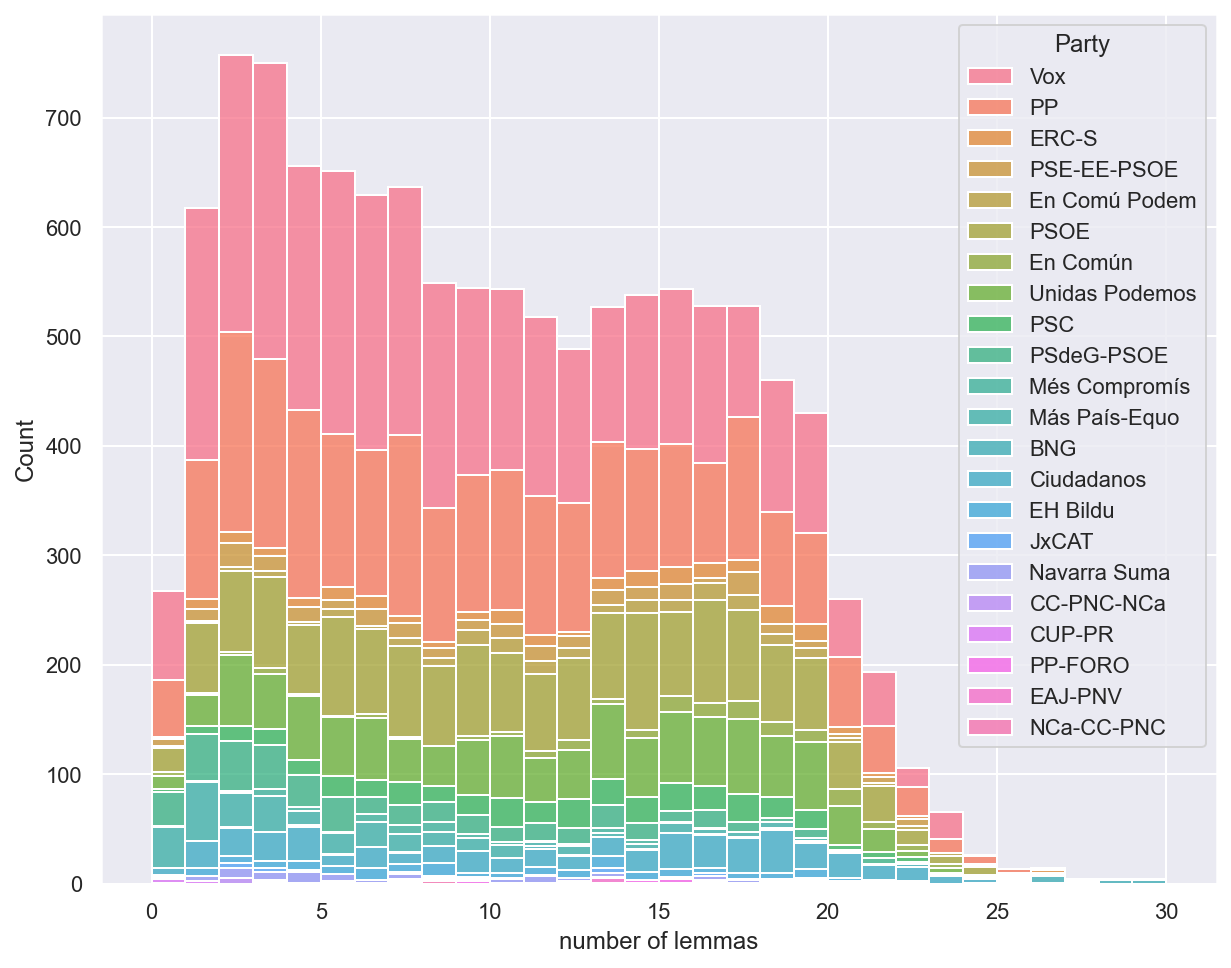

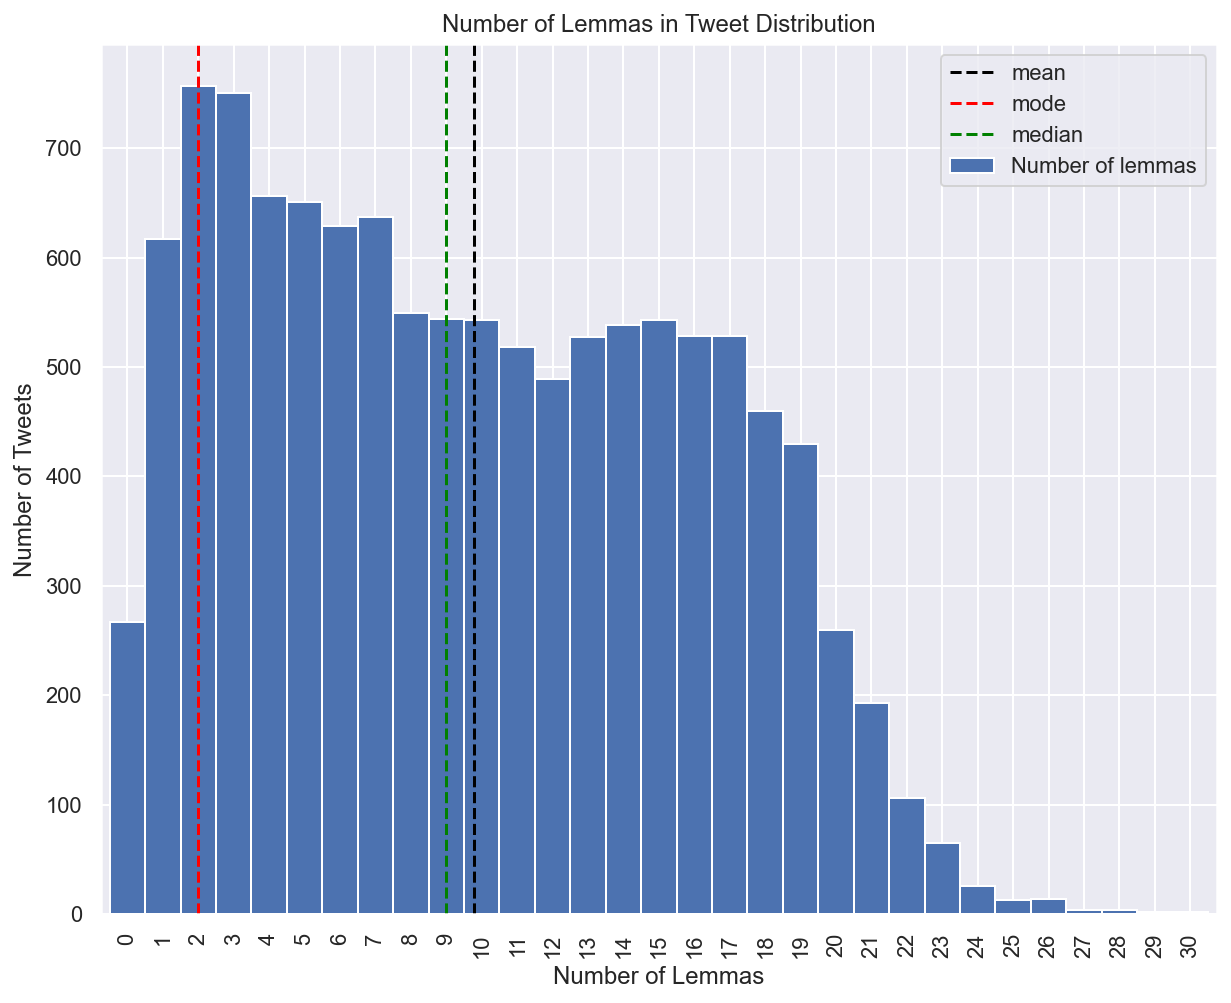

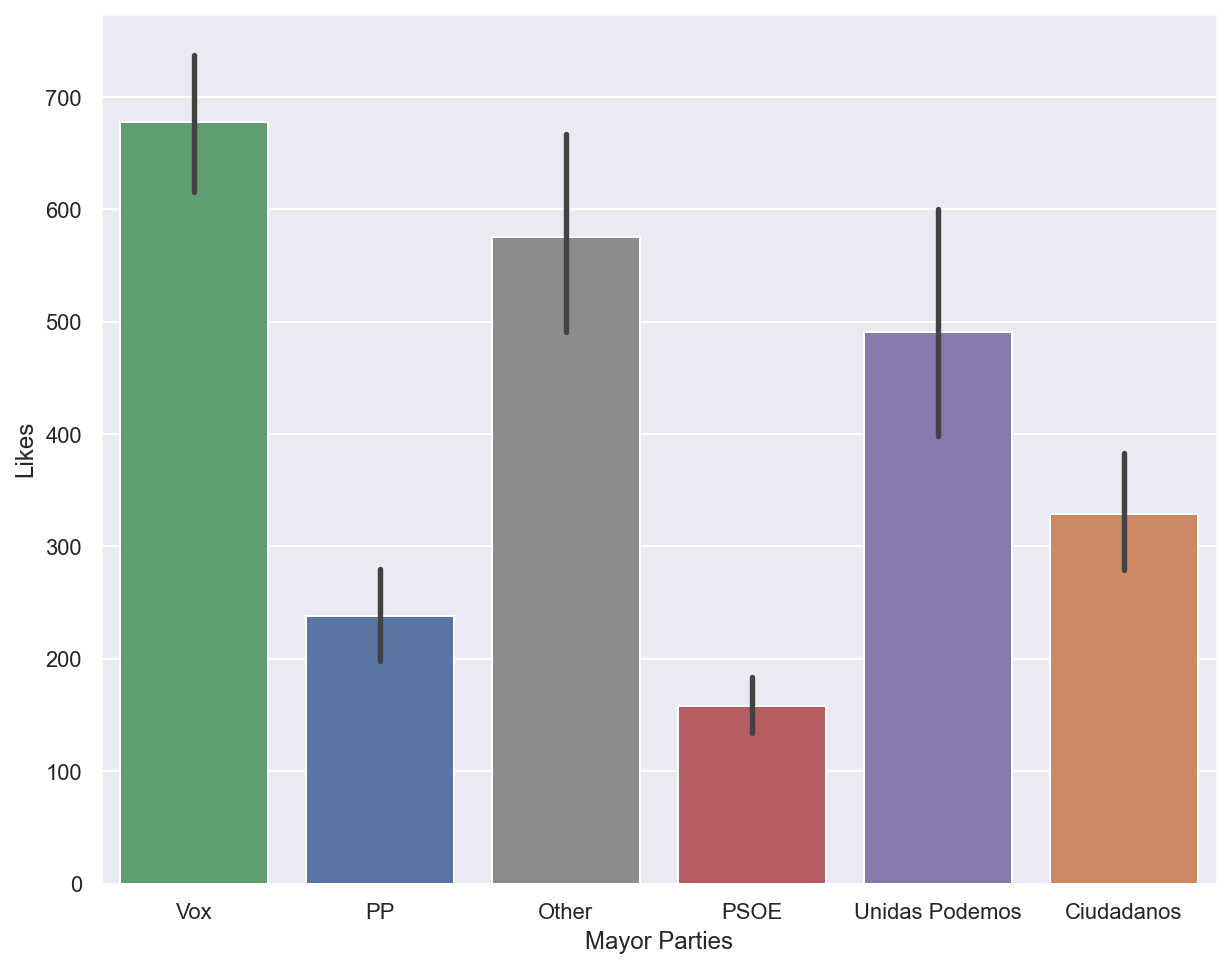

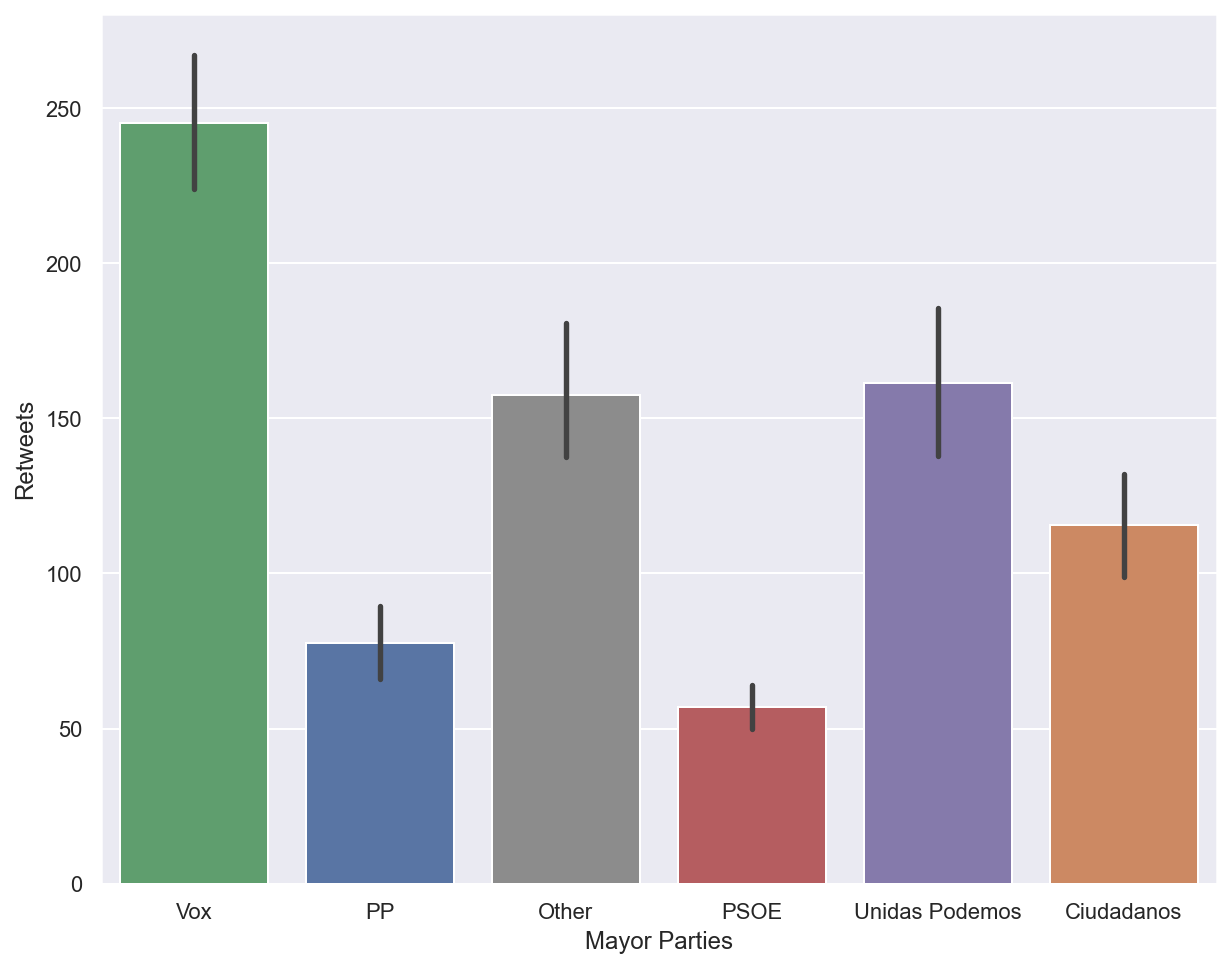

In [185]:
plt.figure()
sns.countplot(data=data, x="Party")
plt.xticks(rotation = 90)
plt.figure()
sns.countplot(data=data, x="Mayor Parties",palette = color_assign)
plt.figure()
sns.histplot(data=data, x="n_lemmas", hue="Party",multiple="stack", bins = 30)
plt.xlabel('number of lemmas')
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar", width=1, label='Number of lemmas')
plt.axvline(x=data['n_lemmas'].mean(),
            label='mean', color='black',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].mode()[0],
            label='mode', color='red',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].median(),
            label='median', color='green',
            linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.figure()
sns.barplot(data = data, x = 'Mayor Parties', y = 'Likes',palette = color_assign)
plt.figure()
sns.barplot(data = data, x = 'Mayor Parties', y = 'Retweets',palette = color_assign)
plt.show()

In [186]:
data = data[data['n_lemmas'] >= 3]
print(f'Number of Tweets in Dataframe after removing short tweets: {len(data)}')

Number of Tweets in Dataframe after removing short tweets: 10209


# Creating the Corpus and Dictionary of terms

In [187]:
def from_df_to_token_dictionary(df, n_lemmas_threshold=3):
    
    df = df[df['n_lemmas'] >= n_lemmas_threshold]
    print(f'Number of Tweets in Dataframe after removing short tweets: {len(df)}')
    
    tweets_corpus = [el.split() for el in df["Lemmas"]]
    # display(tweets_corpus)
    
    df_copy = copy.copy(df)
    
    token_dic = Dictionary(tweets_corpus)
    return token_dic, tweets_corpus, df_copy

In [188]:
token_dict, tweets_corpus, _ = from_df_to_token_dictionary(data, n_lemmas_threshold=3)

Number of Tweets in Dataframe after removing short tweets: 10209


In [189]:
def create_word_freq(token_dic):
    word_freq = {}
    for k, v in token_dic.items():
        word_freq[v] = token_dic.cfs[k]

    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_word_freq

In [190]:
sorted_word_freq = create_word_freq(token_dict)
# print(sorted_word_freq)

# Plot and analysis of term Dictionary stuff

In [191]:
def plot_frequencies(collection):
    collfreq = sorted(collection.items()) 
    x, y = zip(*collfreq) 
    plt.plot(x, y)

In [192]:
def compute_token_mean_max(collection):
    count, _sum = 0, 0
    for key in collection:
        count += 1
        _sum += collection[key]
    
    instances_max = max(collection.values())
    instances_mean = _sum/count
    
    return instances_max, instances_mean

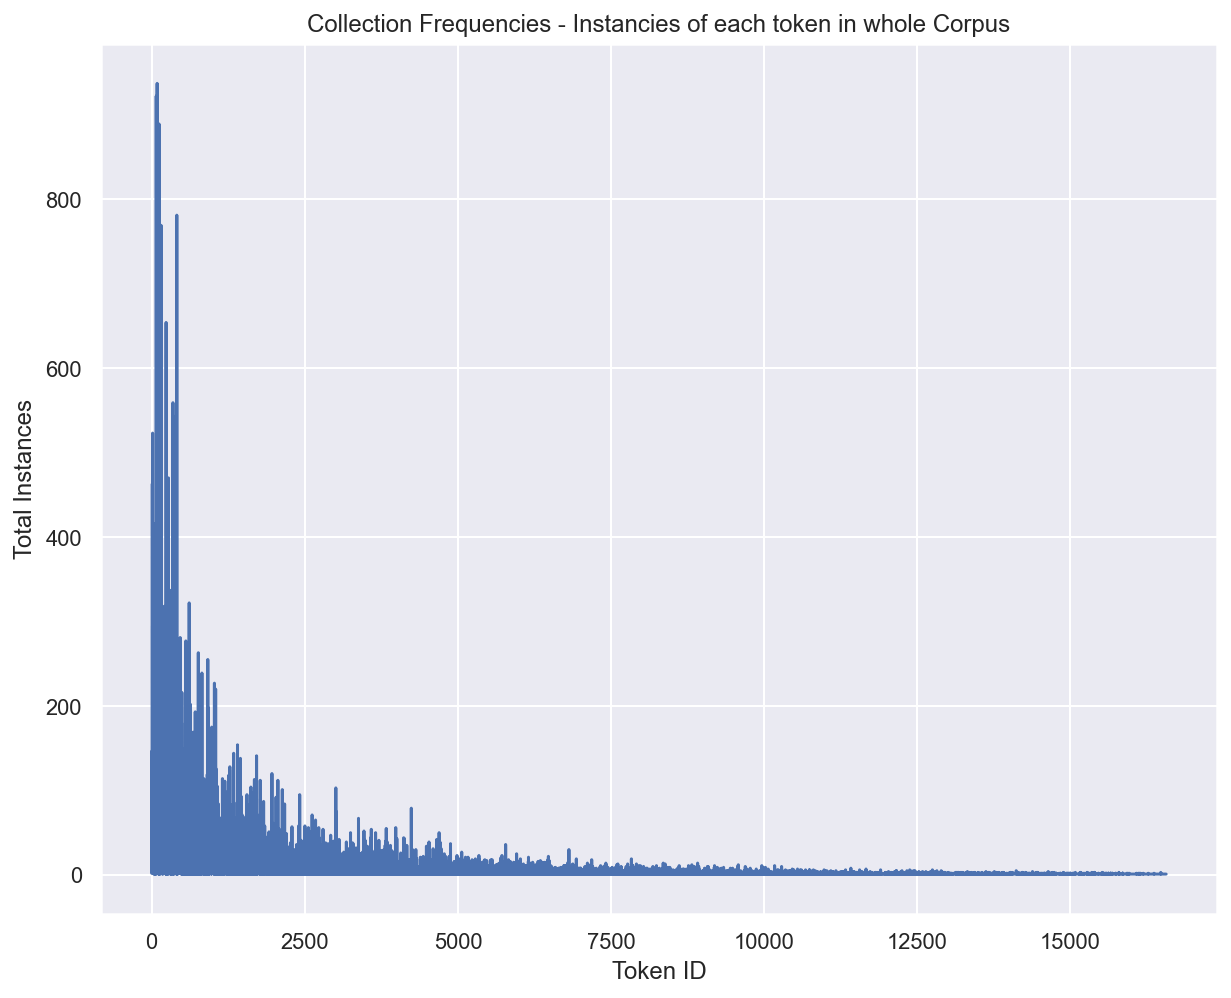

Max of occurances per topic: 937
Mean of occurances per topic: 6.8694680915293125


In [193]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.
plot_frequencies(token_dict.cfs)
plt.title('Collection Frequencies - Instancies of each token in whole Corpus')
plt.xlabel('Token ID')
plt.ylabel('Total Instances')
plt.show()

instances_max, instances_mean = compute_token_mean_max(token_dict.cfs)

print(f"Max of occurances per topic: {instances_max}")
print(f"Mean of occurances per topic: {instances_mean}")

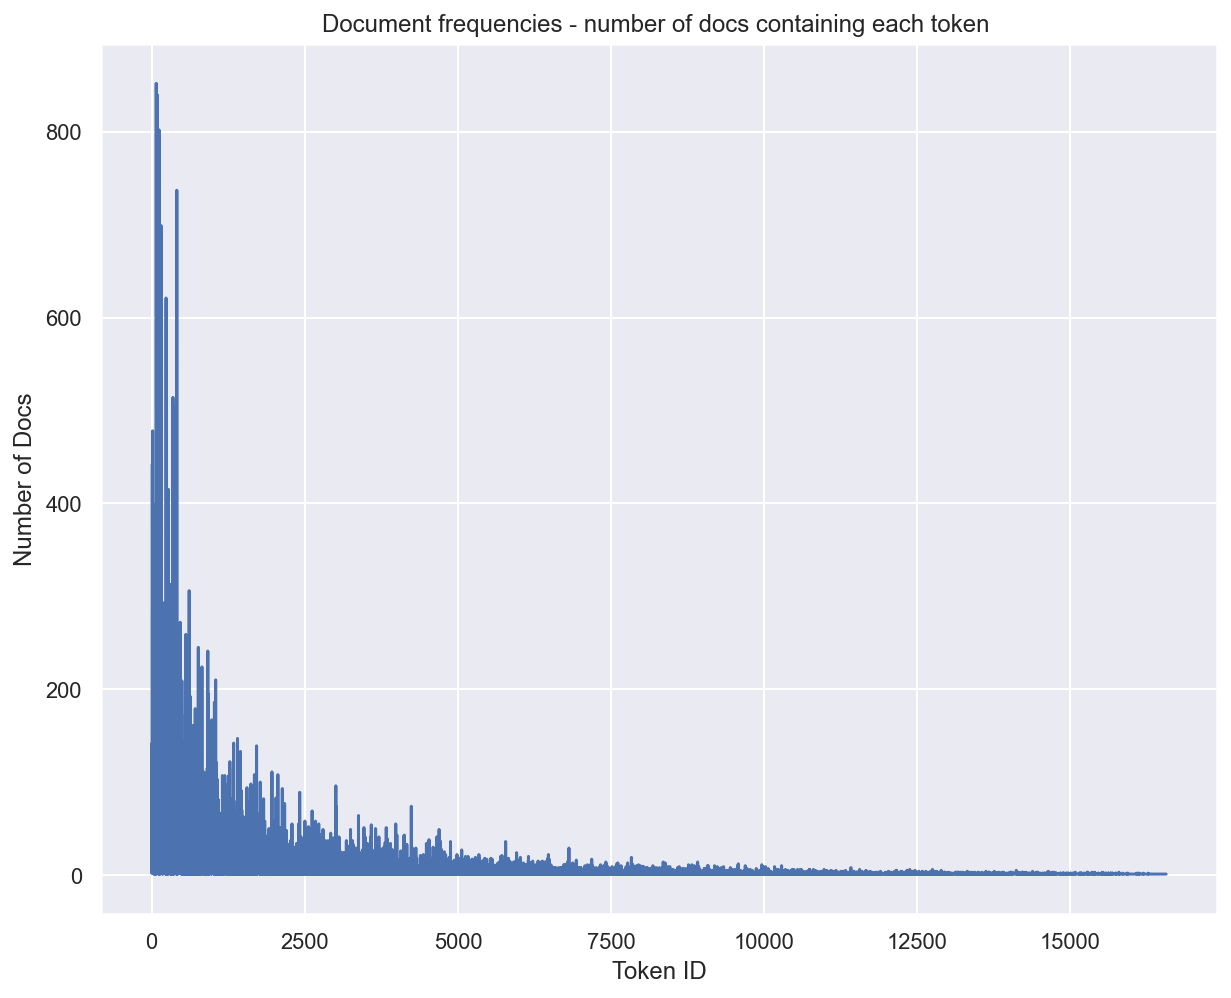

Max of docs in which a token appears: 852
Mean of docs in which token appears: 6.622532149972831


In [194]:
# Document frequencies: token_id -> how many documents contain this token
plot_frequencies(token_dict.dfs)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('Token ID')
plt.ylabel('Number of Docs')
plt.show()

docs_max, docs_mean = compute_token_mean_max(token_dict.dfs)

print(f"Max of docs in which a token appears: {docs_max}")
print(f"Mean of docs in which token appears: {docs_mean}")

# Choosing hyperparameters for filtering extremes

In [195]:
def filter_dict_and_get_bow(token_dict, corpus, below=2, above=1):
    copy_dict = copy.copy(token_dict)
    copy_dict.filter_extremes(no_below=below, no_above=above)
    bow = [copy_dict.doc2bow(doc) for doc in corpus]
    return copy_dict, bow

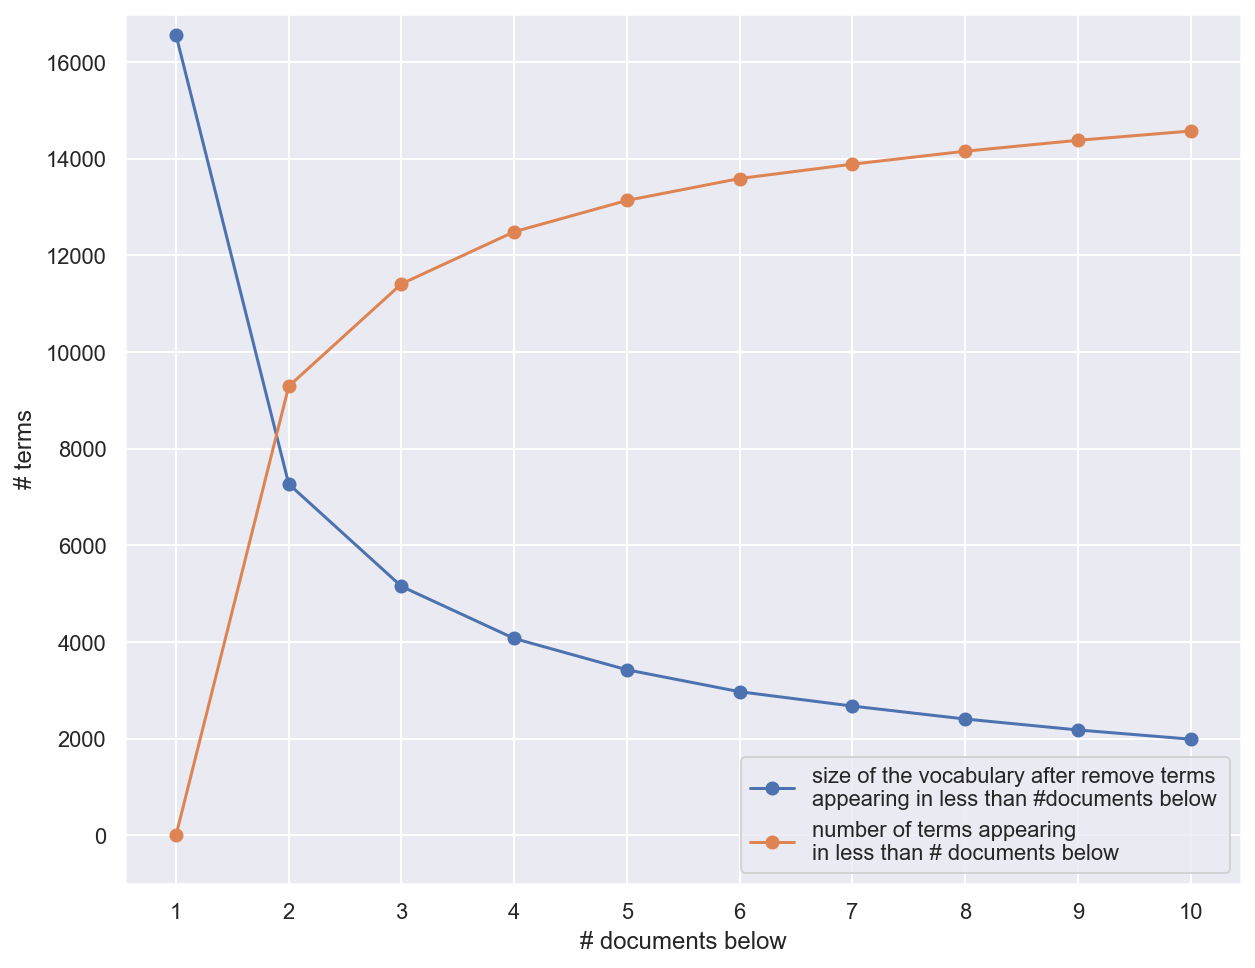

In [196]:
np.array([i[1] for i in sorted(token_dict.dfs.items())])
plt.plot(range(1,11),[len(token_dict) - np.sum(np.array([i[1] for i in sorted(token_dict.dfs.items())])<i) for i in range(1,11)],'o-', 
         label = 'size of the vocabulary after remove terms \nappearing in less than #documents below')
plt.plot(range(1,11),[np.sum(np.array([i[1] for i in sorted(token_dict.dfs.items())])<i) for i in range(1,11)],'o-',
        label = 'number of terms appearing \nin less than # documents below')
plt.xticks(range(1,11),range(1,11))
plt.xlabel('# documents below')
plt.ylabel('# terms')
plt.ylim(-1000,17000)
plt.legend()
plt.show()

# Obtaining BOW from filtered Dictionary

In [197]:
# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)
# filtered_dict = copy.copy(token_dict)

# filtered_dict = filter_dict(token_dict)
# tweets_bow = get_bow(token_dict, tweets_corpus)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)
tweets_corpus_tdidf = TfidfModel(tweets_corpus_bow)
print(f'The dictionary contains {len(filtered_dict)} terms')

The dictionary contains 7270 terms


# Applying LDA and Ploting it for visualization of terms in topics

In [198]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
# mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

In [199]:
def compute_lda(corpus, token_dict, num_topics=15, alpha=5, iterations=100):
    ldamallet = LdaMallet(
        mallet_path,
        corpus=corpus,
        id2word=token_dict,
        num_topics=num_topics,
        alpha=alpha,
        iterations=iterations
    )
    return ldamallet

In [200]:
ldamallet = compute_lda(tweets_corpus_bow, filtered_dict, num_topics=15)

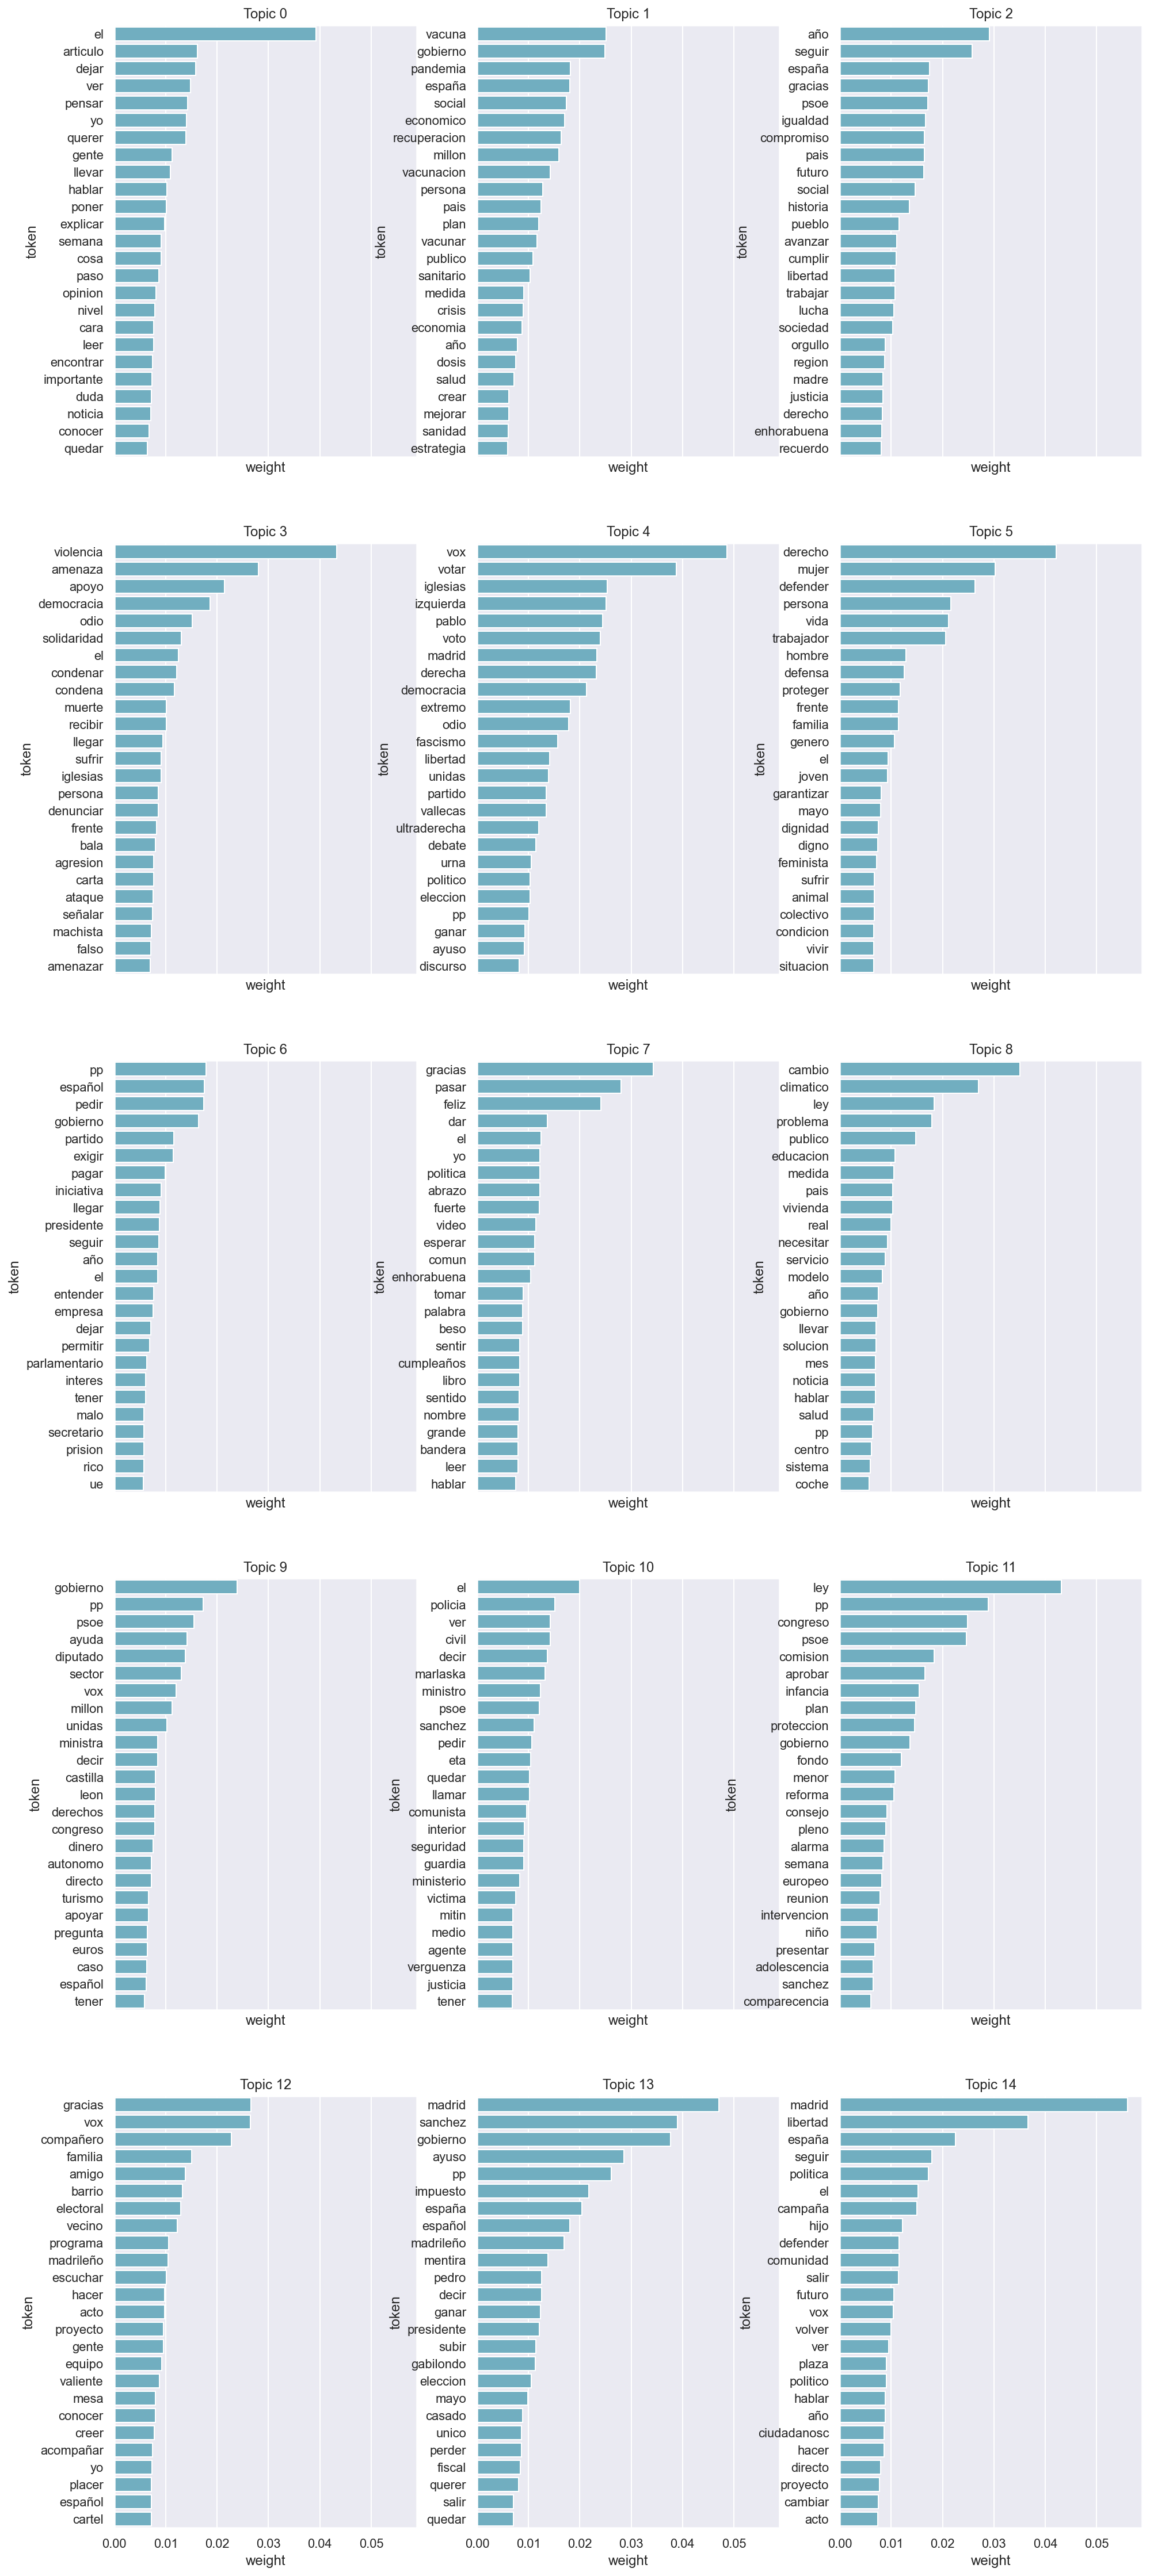

In [201]:
topn = 25
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 40), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

# Specific stopword removal

In [202]:
specific_stw = [
    'el', 'año', 'vivir', 'hacer', 'plan',
    'sector', 'salir', 'gestion', 'resto',
    'ir', 'yo', 'ley', 'gobierno', 'serio',
    'nacional', 'acto', 'minuto', 'explicar',
    'estar', 'poner', 'discurso', 'pedir',
    'volver', 'alto', 'punto', 'pasar', 'pais',
    'dar', 'quedar', 'hablar', 'decir', 'dejar',
    'ver', 'paso', 'importante', 'aprobar', 'gente',
    'dato', 'llegar', 'politica', 'venir', 'leer',
    'seguir', 'entender', 'tener', 'llevar', 'convertir',
    'directo', 'partido', 'cara', 'caso', 'hilo', 'gracia',
    'favor', 'medio', 'forma', 'señor', 'empezar',
    "psoe", "pp", "vox", "ciudadanos", "unidas",
    "angel","pablo", "pedro",
    "isabel", "español", "gracias", "españa",
    "cosa", "mirar", "tweet", "valor", "querer",
    "san", "utilizar", "ojo"
]

# "gracias", "madrid", "españa"

# specific_stw = ["psoe", "pp", "vox", "ciudadanos", "unidas"]

specific_stw = list(set([el.lower() for el in specific_stw]))

In [203]:
def remove_stpwrd(string, specific_stw_eliminate):
    splitted = string.split()
    resultwords = [word for word in splitted if word.lower() not in specific_stw_eliminate]
    return ' '.join(resultwords)

In [204]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_stpwrd(str(x), specific_stw))

data['n_lemmas'] =  data['Lemmas'].str.split().str.len()
#print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(NSF_df))

# Checking filtered results

Number of Tweets in Dataframe after removing short tweets: 9759


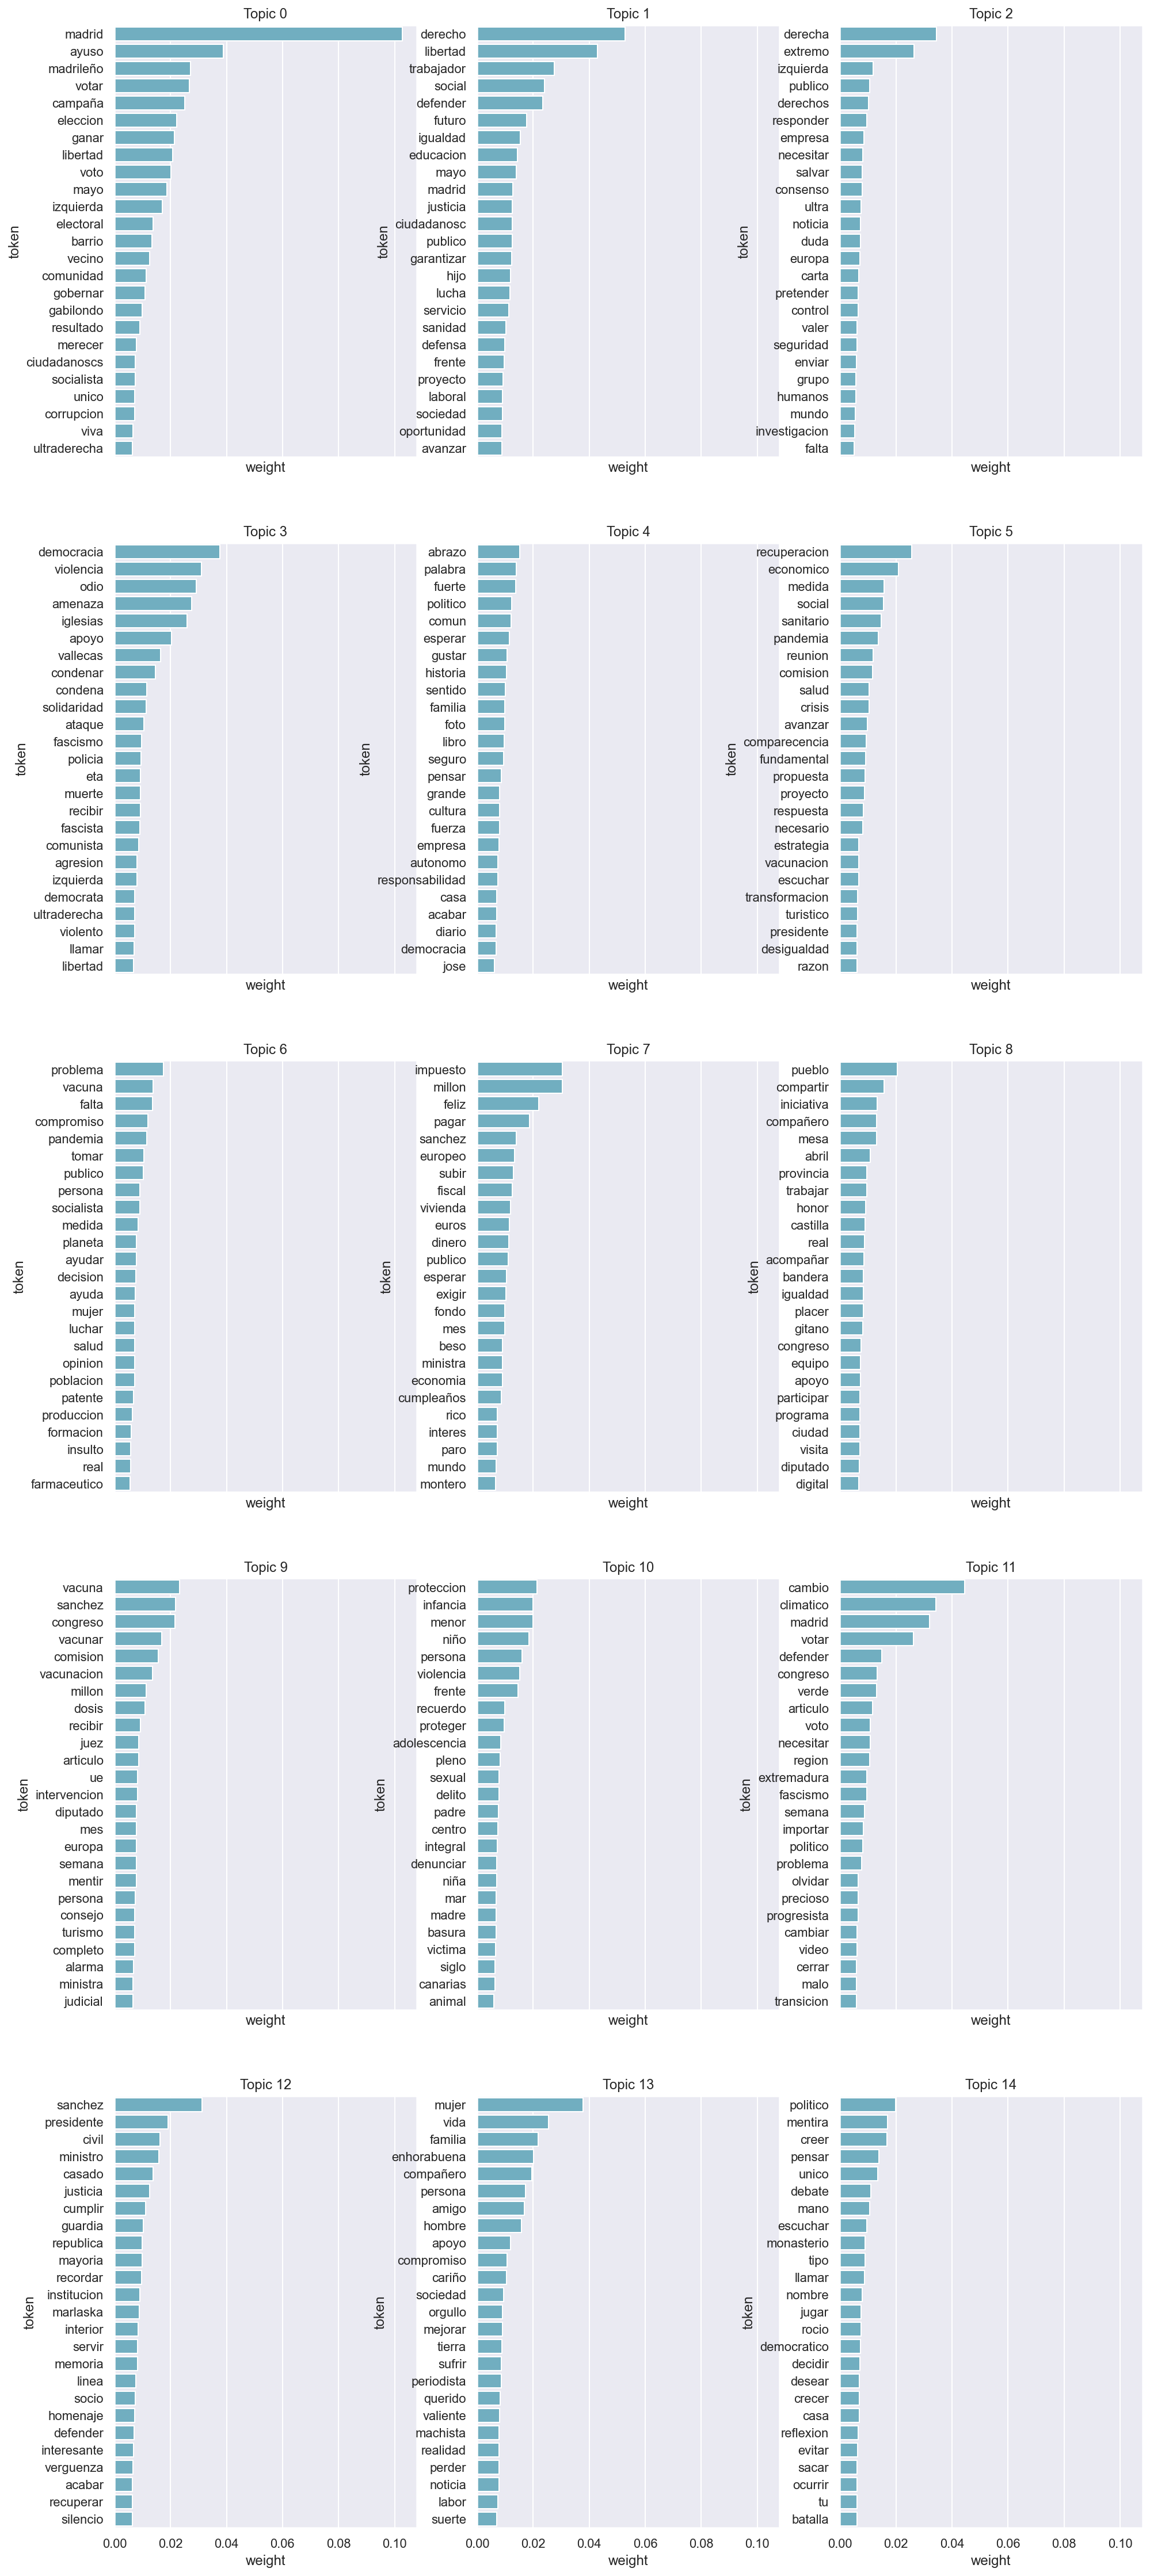

In [205]:
token_dict, tweets_corpus, _ = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)
ldamallet = compute_lda(tweets_corpus_bow, filtered_dict, num_topics=15)
topn = 25
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 40), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

# Choosing hyperparameter number of topics

In [206]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [207]:
token_dict, tweets_corpus, _ = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)

Number of Tweets in Dataframe after removing short tweets: 9759


In [208]:
def compute_lda_coherence(corpus, corpus_bow, token_dict, min_topics=10, max_topics=120, step=10):
    
    topic_coherence = []
    for ntpc in range(min_topics, max_topics + 1, step):
        lda_ntcp = LdaModel(corpus=corpus_bow, id2word=token_dict, num_topics=ntpc)
        topic_coherence.append(
            CoherenceModel(
                lda_ntcp,
                texts=corpus,
                dictionary=token_dict,
                coherence='c_v').get_coherence()
        )
        print(f'Computed model with {ntpc} topics out of {max_topics//step}')
    
    return topic_coherence

# Checking topic coherence from 5 to 150 topics

In [209]:
# topic_coherence = compute_lda_coherence(tweets_corpus, tweets_corpus_bow, filtered_dict, 5,150,15)

# n_topics = range(5, 150, 15)
# plt.figure()
# plt.plot(n_topics, topic_coherence)
# plt.xticks(n_topics, n_topics)
# plt.xlabel('Number of Topics')
# plt.ylabel('Average Coherence')
# plt.show()

# Fine tuning coherence from 3 to 25 topics

In [210]:
# topic_coherence = compute_lda_coherence(tweets_corpus, tweets_corpus_bow, filtered_dict, 3,25,4)

# n_topics = range(3, 25, 4)
# plt.figure()
# plt.plot(n_topics, topic_coherence)
# plt.xticks(n_topics, n_topics)
# plt.xlabel('Number of Topics')
# plt.ylabel('Average Coherence')
# plt.show()

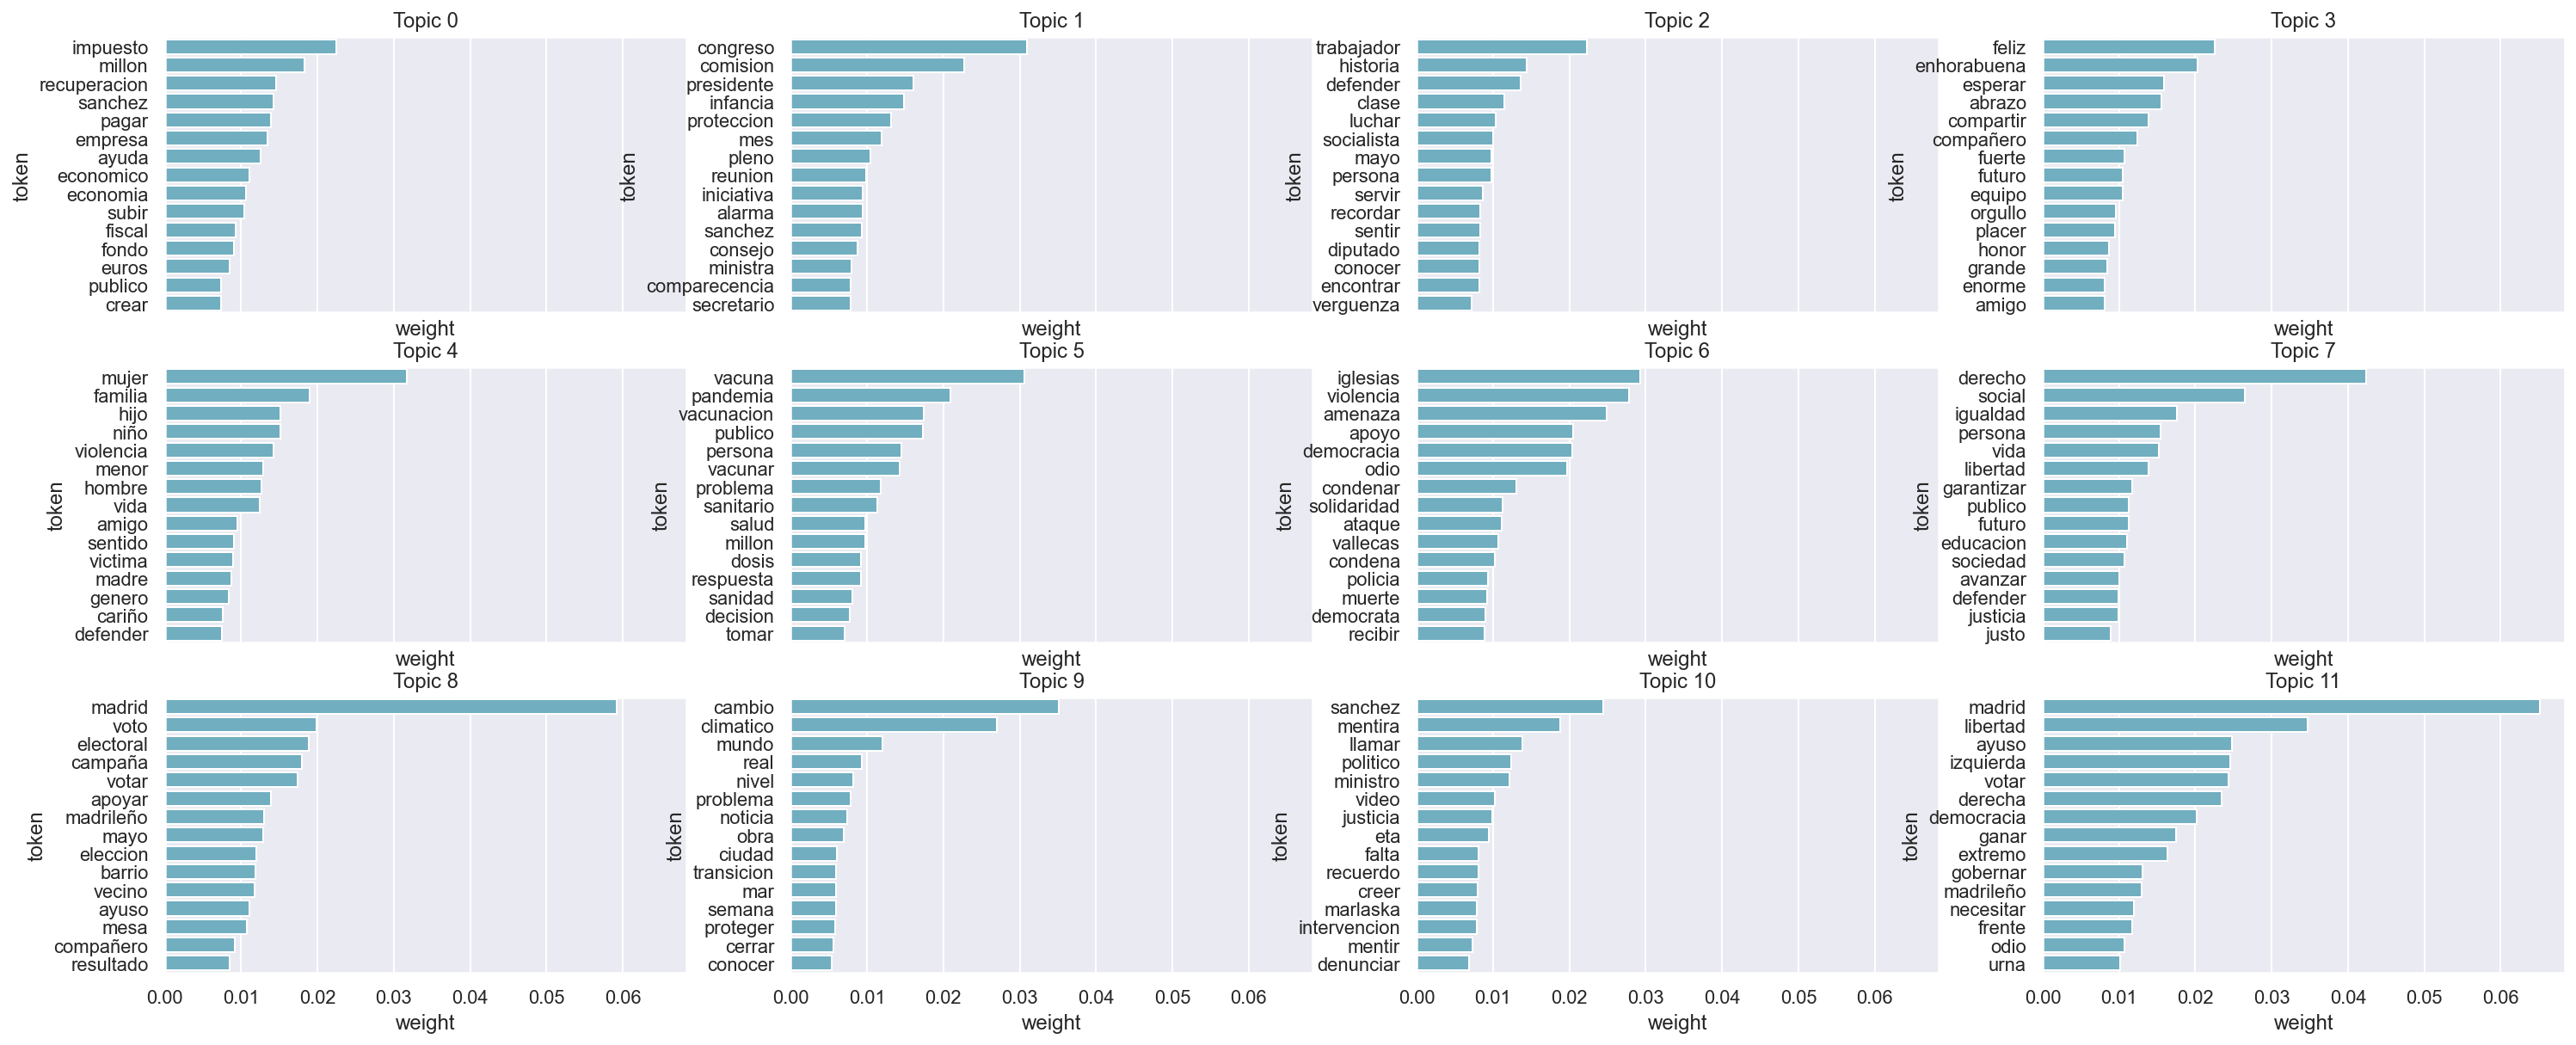

In [211]:
import pickle

ldamallet = pickle.load(open("ldamodel.p", "rb"))
topn = 15
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(25, 10), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

# Definitive LDA model, we are saving it in a pickle

In [212]:
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
import pyLDAvis
from pyLDAvis.gensim_models import prepare

In [213]:
ldamallet = pickle.load(open("ldamodel.p", "rb"))

ldagensim = malletmodel2ldamodel(ldamallet)
#vis_data = prepare(ldagensim, tweets_corpus_bow, filtered_dict)
#pyLDAvis.display(vis_data)

In [214]:
# tpc_descriptions = []

# for ntpc in range(12):
#     print(ldagensim.show_topic(ntpc, topn=20))
#     desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
#     tpc_descriptions.append(desc)

In [215]:
# print(tpc_descriptions)
# pickle.dump(tpc_descriptions, open("topic_descriptions.p", "wb"))

In [216]:
tpc_descriptions = pickle.load(open("topic_descriptions.p", "rb"))

In [217]:

token_dict, tweets_corpus, df = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)
lda_12_topics = [ldagensim[el] for el in tweets_corpus_bow]


rec = []
for topic in lda_12_topics:
    rec.append([value[1] for value in topic])


    
topic_dict= {f"Topic{k}": [] for k in range(12)}
lst = []
for i in lda_12_topics:
    for k, v in i:
        
        topic_dict[f"Topic{k}"] += [v]

main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in lda_12_topics]


Number of Tweets in Dataframe after removing short tweets: 9759


In [218]:
final_df = pd.DataFrame()

final_df["Original_tweet"] = df.sort_index()["Original Tweets"]
final_df["Main_topic"] = main_topic

for k,v in topic_dict.items():
    final_df[k] = v


final_df["LDA_12"] = lda_12_topics 


final_df['Likes'] = df.sort_index()["Likes"].to_list()
final_df['Retweets'] = df.sort_index()["Retweets"].to_list()
final_df["Author"] = df.sort_index()["Author"].to_list()
final_df["Party"] = df.sort_index()["Party"].to_list()
mayor_5_parties = final_df['Party'].value_counts().index[:5]
final_df['Mayor Parties'] = final_df['Party'].apply(lambda x: x if x in mayor_5_parties else 'Other')
final_df.columns = ["Original_tweet", "Main_topic", *tpc_descriptions, "LDA_12", "Likes", "Retweets", "Author", "Party","Mayor Parties"]
final_df

,Original_tweet,Main_topic,Tax increase plan for the European Union,I Congress on Childhood and Adolescence,Working class defense,Congratulations and culture,Discrimination to minorities and victims,Evolution of the vaccination plan and pandemic situation,Threats to left-wing,Society's values,Madrid elections (citizen participation),Climate change,Threats to the welfare state,Madrid elections (candidacies),LDA_12,Likes,Retweets,Author,Party,Mayor Parties
1,Día de homenaje a los españoles deportados y f...,Congratulations and culture,0.263715,0.161249,0.024437,0.268538,0.056516,0.024121,0.024855,0.081025,0.026098,0.023148,0.023148,0.023148,"[(0, 0.2637154988671835), (1, 0.16124939384466...",770,326,José Luis Ábalos Meco,PSOE,PSOE
2,Mi agradecimiento a los interventores y apoder...,Tax increase plan for the European Union,0.217547,0.179715,0.092218,0.045835,0.019639,0.131521,0.019512,0.099210,0.019504,0.091339,0.064494,0.019465,"[(0, 0.2175470348823735), (1, 0.17971506996298...",653,222,José Luis Ábalos Meco,PSOE,PSOE
3,Hemos autorizado las obras de un puente móvil ...,Madrid elections (citizen participation),0.020833,0.020921,0.042855,0.171891,0.077559,0.078124,0.075834,0.021895,0.268298,0.020833,0.180124,0.020833,"[(0, 0.020833333333374955), (1, 0.020920658515...",167,77,José Luis Ábalos Meco,PSOE,PSOE
5,Se cumplen 142 años de la fundación del @PSOE ...,Tax increase plan for the European Union,0.279661,0.024992,0.083333,0.134898,0.024834,0.174105,0.024510,0.141137,0.025497,0.036993,0.024510,0.025530,"[(0, 0.2796614152463948), (1, 0.02499194374853...",421,211,José Luis Ábalos Meco,PSOE,PSOE
7,Junto con los sindicatos @UGT_Comunica y @CCOO...,Threats to the welfare state,0.021930,0.021930,0.021930,0.022465,0.023577,0.021930,0.142229,0.025068,0.022362,0.021983,0.632390,0.022206,"[(0, 0.02192982456140863), (1, 0.0219298245614...",352,136,José Luis Ábalos Meco,PSOE,PSOE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14806,🔴La política de inmigración del Gobierno es pu...,Congratulations and culture,0.034722,0.034722,0.116354,0.267046,0.038173,0.036423,0.035737,0.196971,0.034722,0.034722,0.132027,0.038380,"[(0, 0.03472222222223756), (1, 0.0347222222222...",11,6,Ana María Zurita Expósito,PP,PP
14808,🔵Los diputados canarios del @GPPopular hemos r...,Working class defense,0.026630,0.026042,0.271904,0.026500,0.139847,0.027886,0.043302,0.028718,0.217240,0.026281,0.026042,0.139609,"[(0, 0.026629565005843247), (1, 0.026041666666...",7,6,Ana María Zurita Expósito,PP,PP
14809,🔵Ayer mantuvimos una reunión con @pp_icod para...,Madrid elections (candidacies),0.021008,0.346130,0.019841,0.019841,0.019841,0.028898,0.020567,0.068983,0.019849,0.062751,0.019867,0.352423,"[(0, 0.021007532586373653), (1, 0.346130048269...",4,4,Ana María Zurita Expósito,PP,PP
14810,"📻 Mañana, a partir de las 10:00h, participo en...",Threats to left-wing,0.037879,0.037879,0.037879,0.037879,0.186405,0.037879,0.389523,0.055149,0.037879,0.037879,0.039195,0.064577,"[(0, 0.037878787878821964), (1, 0.037878787878...",10,4,Ana María Zurita Expósito,PP,PP


In [221]:
import openpyxl

# final_df.to_excel('final_tm_df.xlsx', index=False)

In [223]:
final_tm_df = pd.read_excel('final_tm_df.xlsx')

Number of non-zero components in similarity matrix: 95238081
We check the size of the similarity matrix: (9759, 9759)
Ratio of non-zero components: 1.0


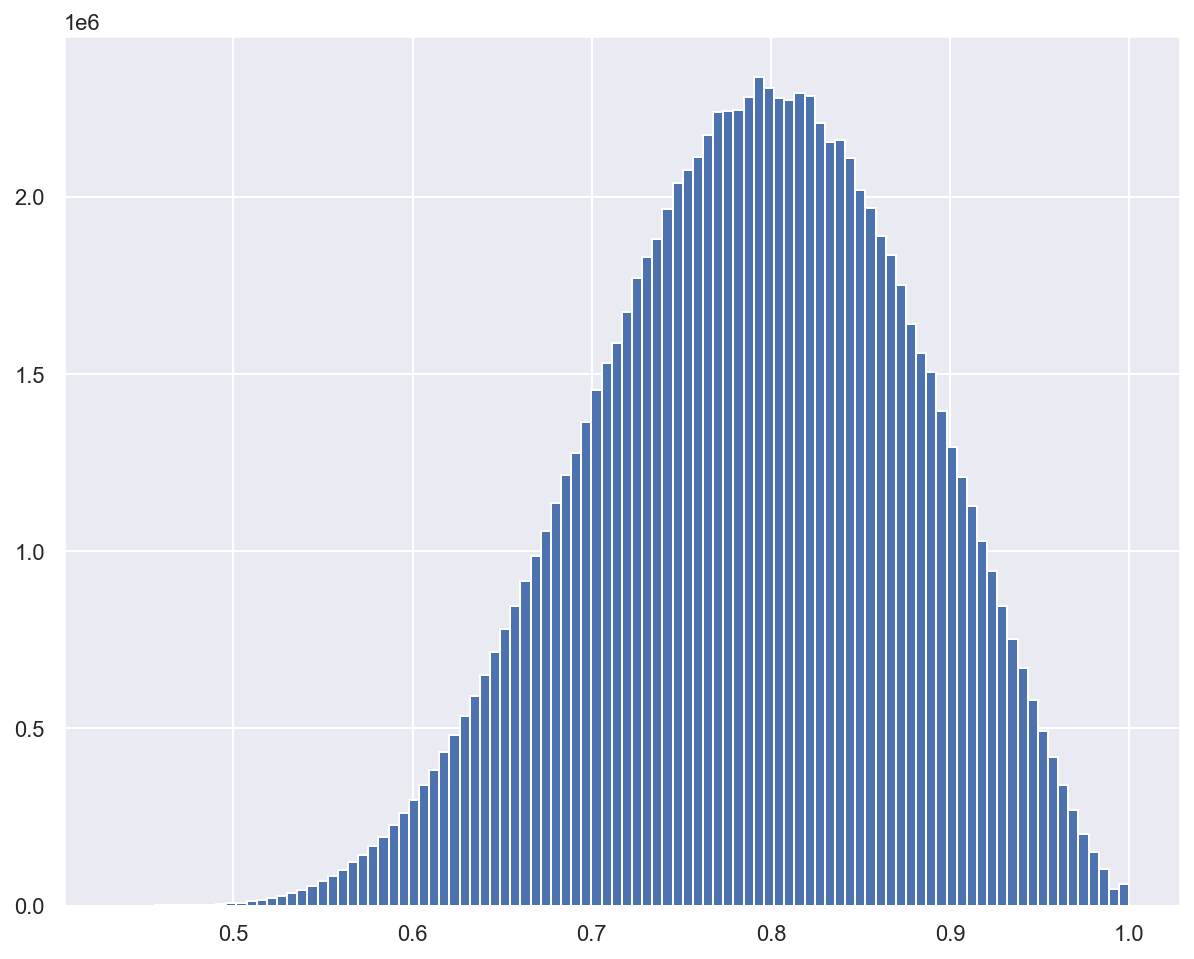

In [224]:
from gensim.matutils import corpus2csc
from scipy.sparse import triu
from ast import literal_eval

sample_size = len(final_tm_df)
corpus_size = len(final_tm_df)
sample_factor = sample_size / corpus_size

X = [literal_eval(el) for el in final_tm_df.sample(sample_size)['LDA_12'].values.tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
#simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part

print('Number of non-zero components in similarity matrix:', len(simmat.data))
print('We check the size of the similarity matrix:', simmat.shape)
print('Ratio of non-zero components:', len(simmat.data)/simmat.shape[0]/simmat.shape[1])

plt.hist(simmat.data, bins=100)
plt.show()

In [225]:
thr = 0.6
simmat.data = np.where(simmat.data > thr, 0, simmat.data)
simmat.eliminate_zeros()
len(simmat.data)
print('Estimated number of links in full corpus:', len(simmat.data)/2/sample_factor**2)

Estimated number of links in full corpus: 858487.0


In [226]:
sample_size = 2000
print('Creating a graph with', sample_size, 'nodes')
final_tm_df_sample = final_tm_df.sample(sample_size)
final_tm_df_sample['Id'] = [el for el in np.arange(sample_size)]
# final_tm_df_sample[['Id', 'Likes', 'Retweets', 'Author', 'Party', 'Main_topic']].to_csv('final_tm_nodes.csv', index=False)

Creating a graph with 2000 nodes


In [227]:
X = [literal_eval(el) for el in final_tm_df_sample['LDA_12'].values.tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
simmat.data = np.where(simmat.data > thr, 0, simmat.data)
simmat.eliminate_zeros()
simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part
print('Number of links in sampled corpus:', len(simmat.data))
simmat = simmat.tocoo()

Number of links in sampled corpus: 29394


In [228]:
# pd.DataFrame([el for el in zip(simmat.row.tolist(),simmat.col.tolist(),simmat.data.tolist())],
#              columns=['Source','Target','Weight']).to_csv('final_tm_edges.csv', index=False)

# Here we start Task 2

In [229]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_text
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import label_binarize
from sklearn import svm

In [230]:
#we separate our data into training and test

del final_df['LDA_12']
del final_df['Author']

df_test, df_train = train_test_split(final_df, test_size=0.8, random_state=420)


Y_train = df_train['Mayor Parties']
X_train = df_train.iloc[:,2:-2]

Y_test = df_test['Mayor Parties']
X_test = df_test.iloc[:,2:-2]

In [231]:
#we will first normalize our data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

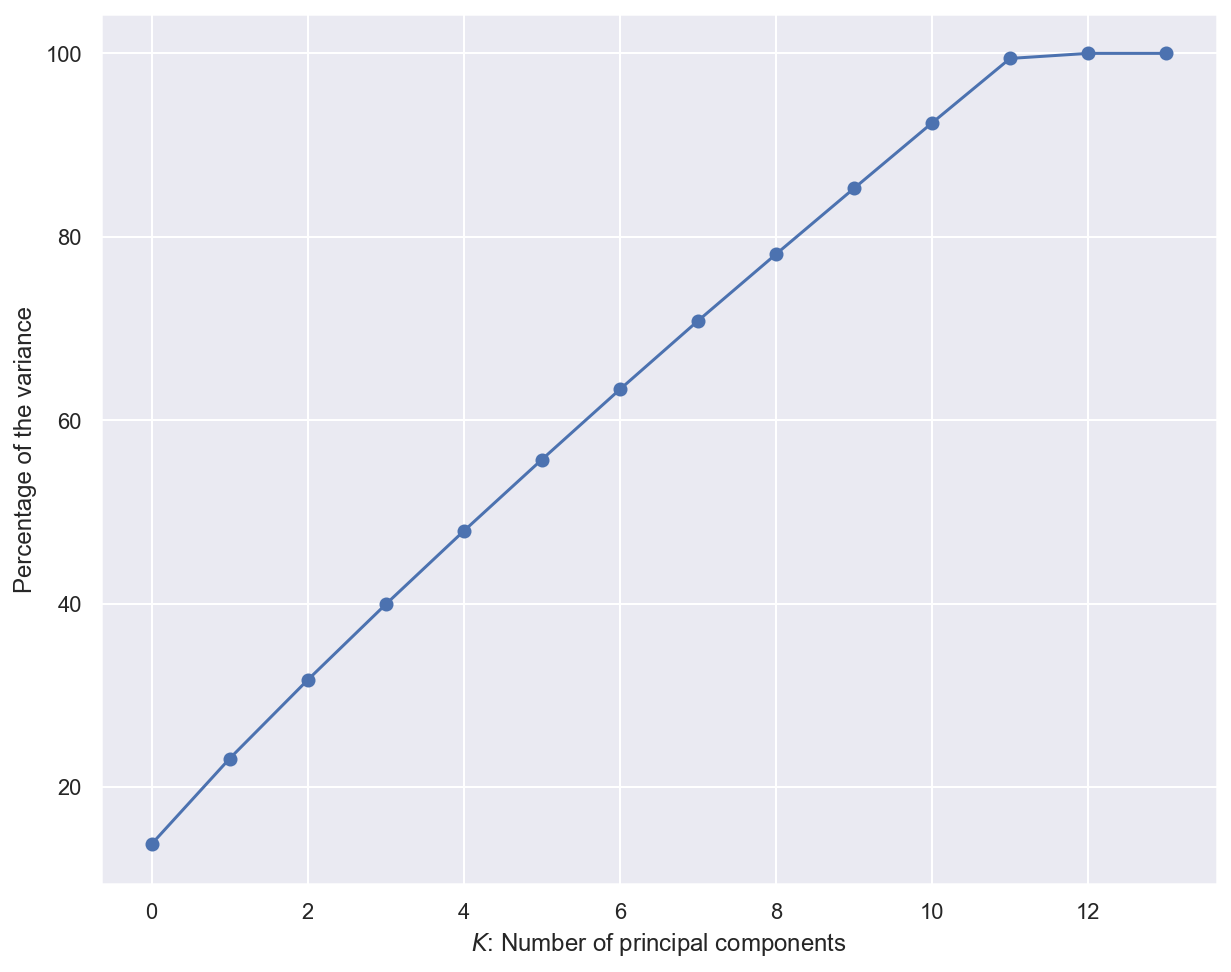

In [232]:
#we check how some dimensionality reduction techniques work
pca = PCA(n_components=X_train.shape[1]).fit(X_train)
eigenvalues = pca.explained_variance_


data_variance = np.sum(np.var(X_train,0))

plt.figure()
plt.plot(100*np.cumsum(eigenvalues)/data_variance, 'o-',label='Evolution eigenvalues')
plt.xlabel('$K$: Number of principal components')
plt.ylabel('Percentage of the variance')
plt.show()
#Most of the variance is explained by most of the components except the last two and the ammount of 
# variance explained by each of these other components is almost the same
# As we have very few variables a dimensionality reduction technique might not be very convenient.
# These two reasons make for our decision of not

In [233]:
def SVM_accuracy_evolution(X_train_t, Y_train, X_test_t, Y_test, rang_feat):
    """Compute the accuracy of training and test data for different the number of features

    Args:
        X_train_t (numpy dnarray): training data projected in the new feature space (number data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number data x 1).
        X_test_t (numpy dnarray): test data projected in the new feature space (number data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number data x 1).                                     
        rang_feat: range with different number of features to be evaluated 
    """
    
    # Define the model to train a liner SVM
    clf = svm.SVC(kernel='rbf')
    
    acc_tr = np.empty(X_train_t.shape[1]-1)
    acc_test = np.empty(X_train_t.shape[1]-1)
    for i in rang_feat:
        # Train SVM classifier
        clf.fit(X_train_t[:,:i], Y_train)

        # Compute train, val and test accuracies and save in acc_tr, acc_val and acc_test
        acc_tr[i-1] =  clf.score(X_train_t[:,:i], Y_train)
        acc_test[i-1] = clf.score(X_test_t[:,:i], Y_test)

    return acc_tr,acc_test

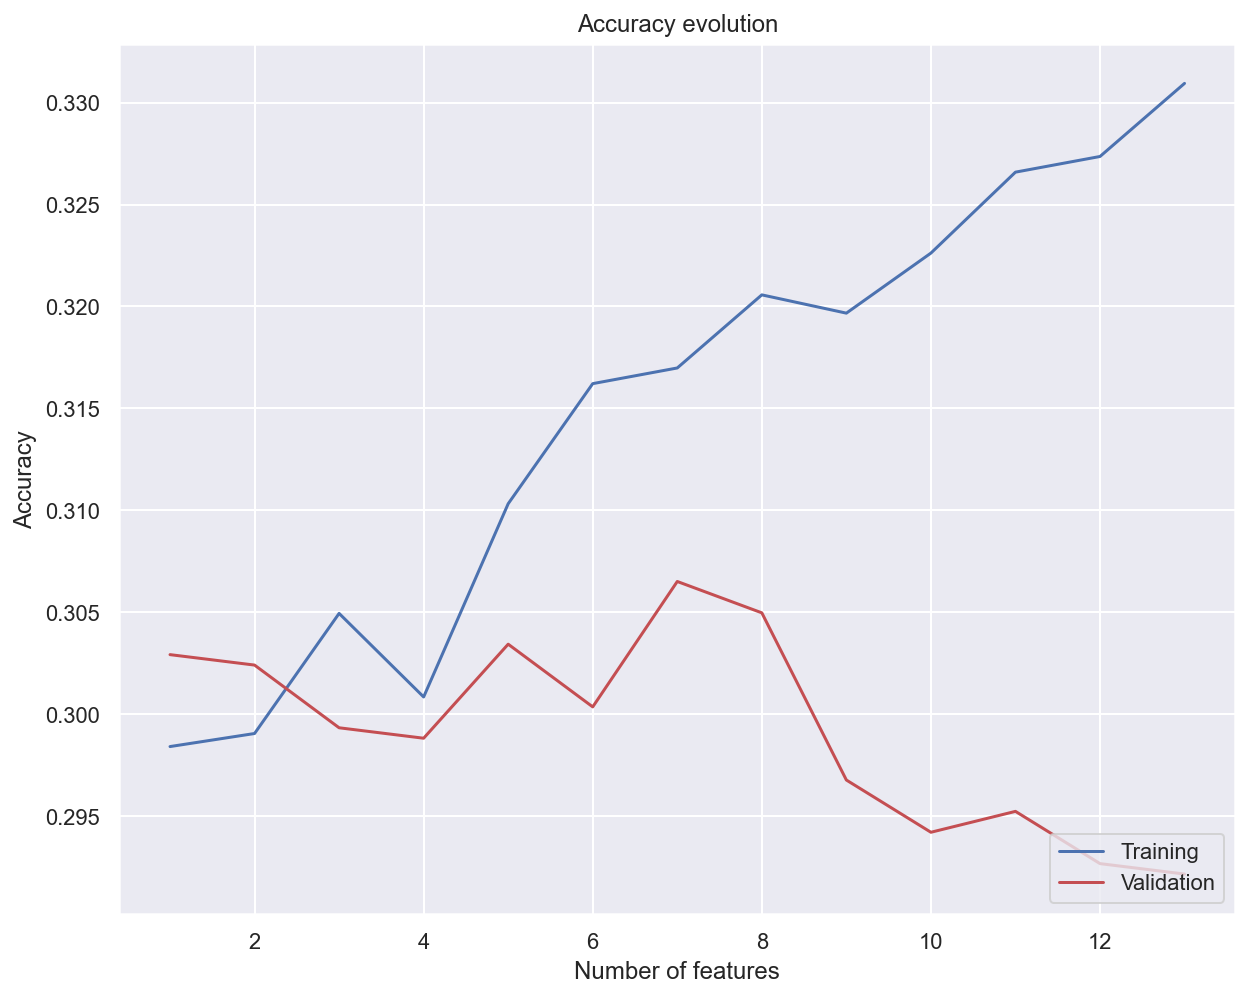

In [234]:
P_train = pca.transform(X_train)
P_test = pca.transform(X_test)
N_feat_max = X_train.shape[1]

rang_feat = np.arange(1, N_feat_max, 1)
[acc_tr, acc_test] = SVM_accuracy_evolution(P_train, Y_train, P_test, Y_test, rang_feat)

plt.figure()
plt.plot(range(1,P_train.shape[1]),acc_tr, "b", label="train")
plt.plot(range(1,P_train.shape[1]),acc_test, "r", label="test")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title('Accuracy evolution')
plt.legend(['Training', 'Validation', 'Test'], loc = 4)
plt.show()

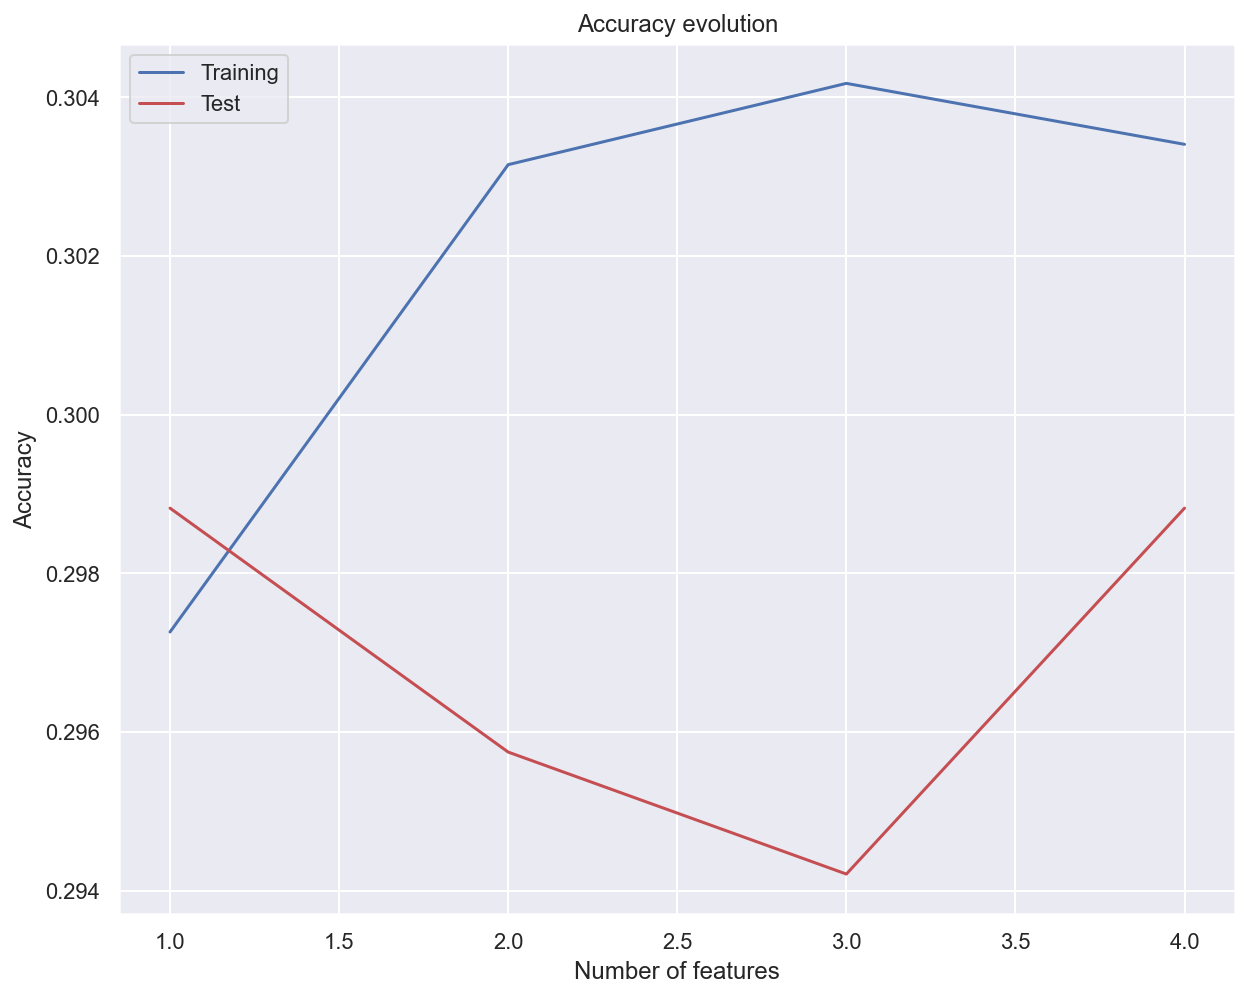

Number optimum of features: 1
The optimum test accuracy is  29.88%


In [235]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import label_binarize
Y_train_bin = label_binarize(Y_train, classes=list(Y_train.unique()))
N_feat_max = Y_train.unique().size-1
cca = CCA(n_components=N_feat_max)
cca.fit(X_train, Y_train_bin)

P_train_cca = cca.transform(X_train)
P_test_cca = cca.transform(X_test)

rang_feat = np.arange(1, N_feat_max, 1)
[acc_tr, acc_test] = SVM_accuracy_evolution(P_train_cca, Y_train, P_test_cca, Y_test, rang_feat)

plt.figure()
plt.plot(range(1,P_train_cca.shape[1]),acc_tr, "b", label="train")
plt.plot(range(1,P_train_cca.shape[1]),acc_test, "r", label="test")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title('Accuracy evolution')
plt.legend(['Training', 'Test'])
plt.show()

pos_max = np.argmax(acc_test)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print('Number optimum of features: %d' %(num_opt_feat))
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

In [236]:
# IMPORTANTE as we have very few variables a dimensionality reduction technique might not be very convenient

In [237]:
# the accuracy is not high enough to give a good confidence on future data


In [238]:
#as our models are not performing very well (probably due to the nature of our data)
# the model that we are going to choose is a decision tree

## the reasons
# it wont perform as good (as bad really) as random forest or other 
# classification techniques that we already have tried
# BUT those techniques haven't work with a good performance so.
# The most important part of our proyect is interpretability and beaing able to extract knowledge from the data
# that is why a decision tree will serve us good
# it doesnt rely on scaling the data (so we can let untouched our likes and retweets and see 
# if they take part on the classification decision)
# and, if we dont do linearn combinations of our data (that means no PCA), 
# we will have rules that apply over likes, retweets and the probability values of our selected topics 
# returned by the LDA which are features that we know well how to interpret.
# a Decision tree's criterion for creating branches acts as an embedded feature selector 

#we will reload our data 
Y_train = df_train['Mayor Parties']
X_train = df_train.iloc[:,2:-2]

Y_test = df_test['Mayor Parties']
X_test = df_test.iloc[:,2:-2]

In [239]:
max_depth = range(2,14)
criterion = ['gini', 'entropy']
clf_GS = GridSearchCV(estimator = DecisionTreeClassifier(), 
                      param_grid = {'criterion':criterion,'max_depth':max_depth},
                      n_jobs = -1)
clf_GS.fit(X_train, Y_train)

print(clf_GS.best_score_)
print(clf_GS.best_params_)

tree_classifier = DecisionTreeClassifier(**clf_GS.best_params_).fit(X_train,Y_train)
print('Accuracy on trainset: ',tree_classifier.score(X_train,Y_train))
print('Accuracy on testset: ',tree_classifier.score(X_test,Y_test))

0.33939445888539554
{'criterion': 'gini', 'max_depth': 3}
Accuracy on trainset:  0.34157274590163933
Accuracy on testset:  0.33470015376729884


In [240]:
print(export_text(tree_classifier, feature_names=list(final_df.columns[2:-2])))

|--- Likes <= 33.50
|   |--- Retweets <= 1.50
|   |   |--- Likes <= 1.50
|   |   |   |--- class: Vox
|   |   |--- Likes >  1.50
|   |   |   |--- class: PP
|   |--- Retweets >  1.50
|   |   |--- Likes <= 17.50
|   |   |   |--- class: PP
|   |   |--- Likes >  17.50
|   |   |   |--- class: PP
|--- Likes >  33.50
|   |--- Retweets <= 549.50
|   |   |--- Retweets <= 16.50
|   |   |   |--- class: Vox
|   |   |--- Retweets >  16.50
|   |   |   |--- class: Vox
|   |--- Retweets >  549.50
|   |   |--- Likes <= 2632.00
|   |   |   |--- class: Vox
|   |   |--- Likes >  2632.00
|   |   |   |--- class: Vox



In [241]:
# we now see that the tree does not explain anything it only takes the likes and retweets
# so we will repeat without them


In [242]:
max_depth = range(2,14)
criterion = ['gini', 'entropy']
clf_GS = GridSearchCV(estimator = DecisionTreeClassifier(), 
                      param_grid = {'criterion':criterion,'max_depth':max_depth},
                      n_jobs = -1)
clf_GS.fit(X_train.iloc[:,:-2], Y_train)

print(clf_GS.best_score_)
print(clf_GS.best_params_)

tree_classifier = DecisionTreeClassifier(**clf_GS.best_params_).fit(X_train.iloc[:,:-2],Y_train)
print('Accuracy on trainset: ',tree_classifier.score(X_train.iloc[:,:-2],Y_train))
print('Accuracy on testset: ',tree_classifier.score(X_test.iloc[:,:-2],Y_test))

0.29687493079143434
{'criterion': 'gini', 'max_depth': 2}
Accuracy on trainset:  0.2977715163934426
Accuracy on testset:  0.2993336750384418


In [243]:
print(export_text(tree_classifier, feature_names=list(final_df.columns[2:-4])))

|--- Congratulations and culture <= 0.38
|   |--- Climate change <= 0.61
|   |   |--- class: Vox
|   |--- Climate change >  0.61
|   |   |--- class: Vox
|--- Congratulations and culture >  0.38
|   |--- Threats to the welfare state <= 0.03
|   |   |--- class: PSOE
|   |--- Threats to the welfare state >  0.03
|   |   |--- class: Vox



In [244]:
# We see that it only classifies for Vox and PSOE#

In [245]:
# after all we conclude that due to the nature of our dataset, a classification task 
# of predicting to which party a tweet belongs is not an easy task and probably 
# not the most enlightening question to make.